## Modeling to Predict Credit Limit using Regression Algorithms

### Jennifer Brosnahan, MPH

The purpose of this notebook is to compare and contrast 4 regression models for predicting credit limit based on demographic and financial history features. Feature selection and tuning will be utilized to see which regression algorithm comes out on top.

In [1]:
# import libraries
# numpy, pandas, scipy, math, matplotlib
import numpy as np
import pandas as pd
import scipy
from math import sqrt
import matplotlib.pyplot as plt
import seaborn as sns
from pprint import pprint

# helpers
%matplotlib inline

# estimators
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR, SVC
from sklearn import linear_model
from xgboost import XGBRegressor

# model metrics
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV

### Load dataset using Pandas

In [2]:
# data
credit = pd.read_excel(r'C:\Users\jlbro\OneDrive\C2T2\credit.xlsx')
credit.head()

,LIMIT_BAL,SEX,AGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,...,age_4,age_6,EDUCATION_graduate school,EDUCATION_high school,EDUCATION_other,EDUCATION_university,MARRIAGE_divorced,MARRIAGE_married,MARRIAGE_other,MARRIAGE_single
0,20000,2,24,2,2,0,0,0,0,3913,...,0,0,0,0,0,1,0,1,0,0
1,120000,2,26,0,2,0,0,0,2,2682,...,0,0,0,0,0,1,0,0,0,1
2,90000,2,34,0,0,0,0,0,0,29239,...,1,2,0,0,0,1,0,0,0,1
3,50000,2,37,0,0,0,0,0,0,46990,...,2,3,0,0,0,1,0,1,0,0
4,50000,1,57,0,0,0,0,0,0,8617,...,3,5,0,0,0,1,0,1,0,0


In [3]:
# examining structure to ensure correct format for modeling
credit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29965 entries, 0 to 29964
Data columns (total 32 columns):
 #   Column                     Non-Null Count  Dtype
---  ------                     --------------  -----
 0   LIMIT_BAL                  29965 non-null  int64
 1   SEX                        29965 non-null  int64
 2   AGE                        29965 non-null  int64
 3   PAY_1                      29965 non-null  int64
 4   PAY_2                      29965 non-null  int64
 5   PAY_3                      29965 non-null  int64
 6   PAY_4                      29965 non-null  int64
 7   PAY_5                      29965 non-null  int64
 8   PAY_6                      29965 non-null  int64
 9   BILL_AMT1                  29965 non-null  int64
 10  BILL_AMT2                  29965 non-null  int64
 11  BILL_AMT3                  29965 non-null  int64
 12  BILL_AMT4                  29965 non-null  int64
 13  BILL_AMT5                  29965 non-null  int64
 14  BILL_AMT6             

#### Feature Selection using Filtering method

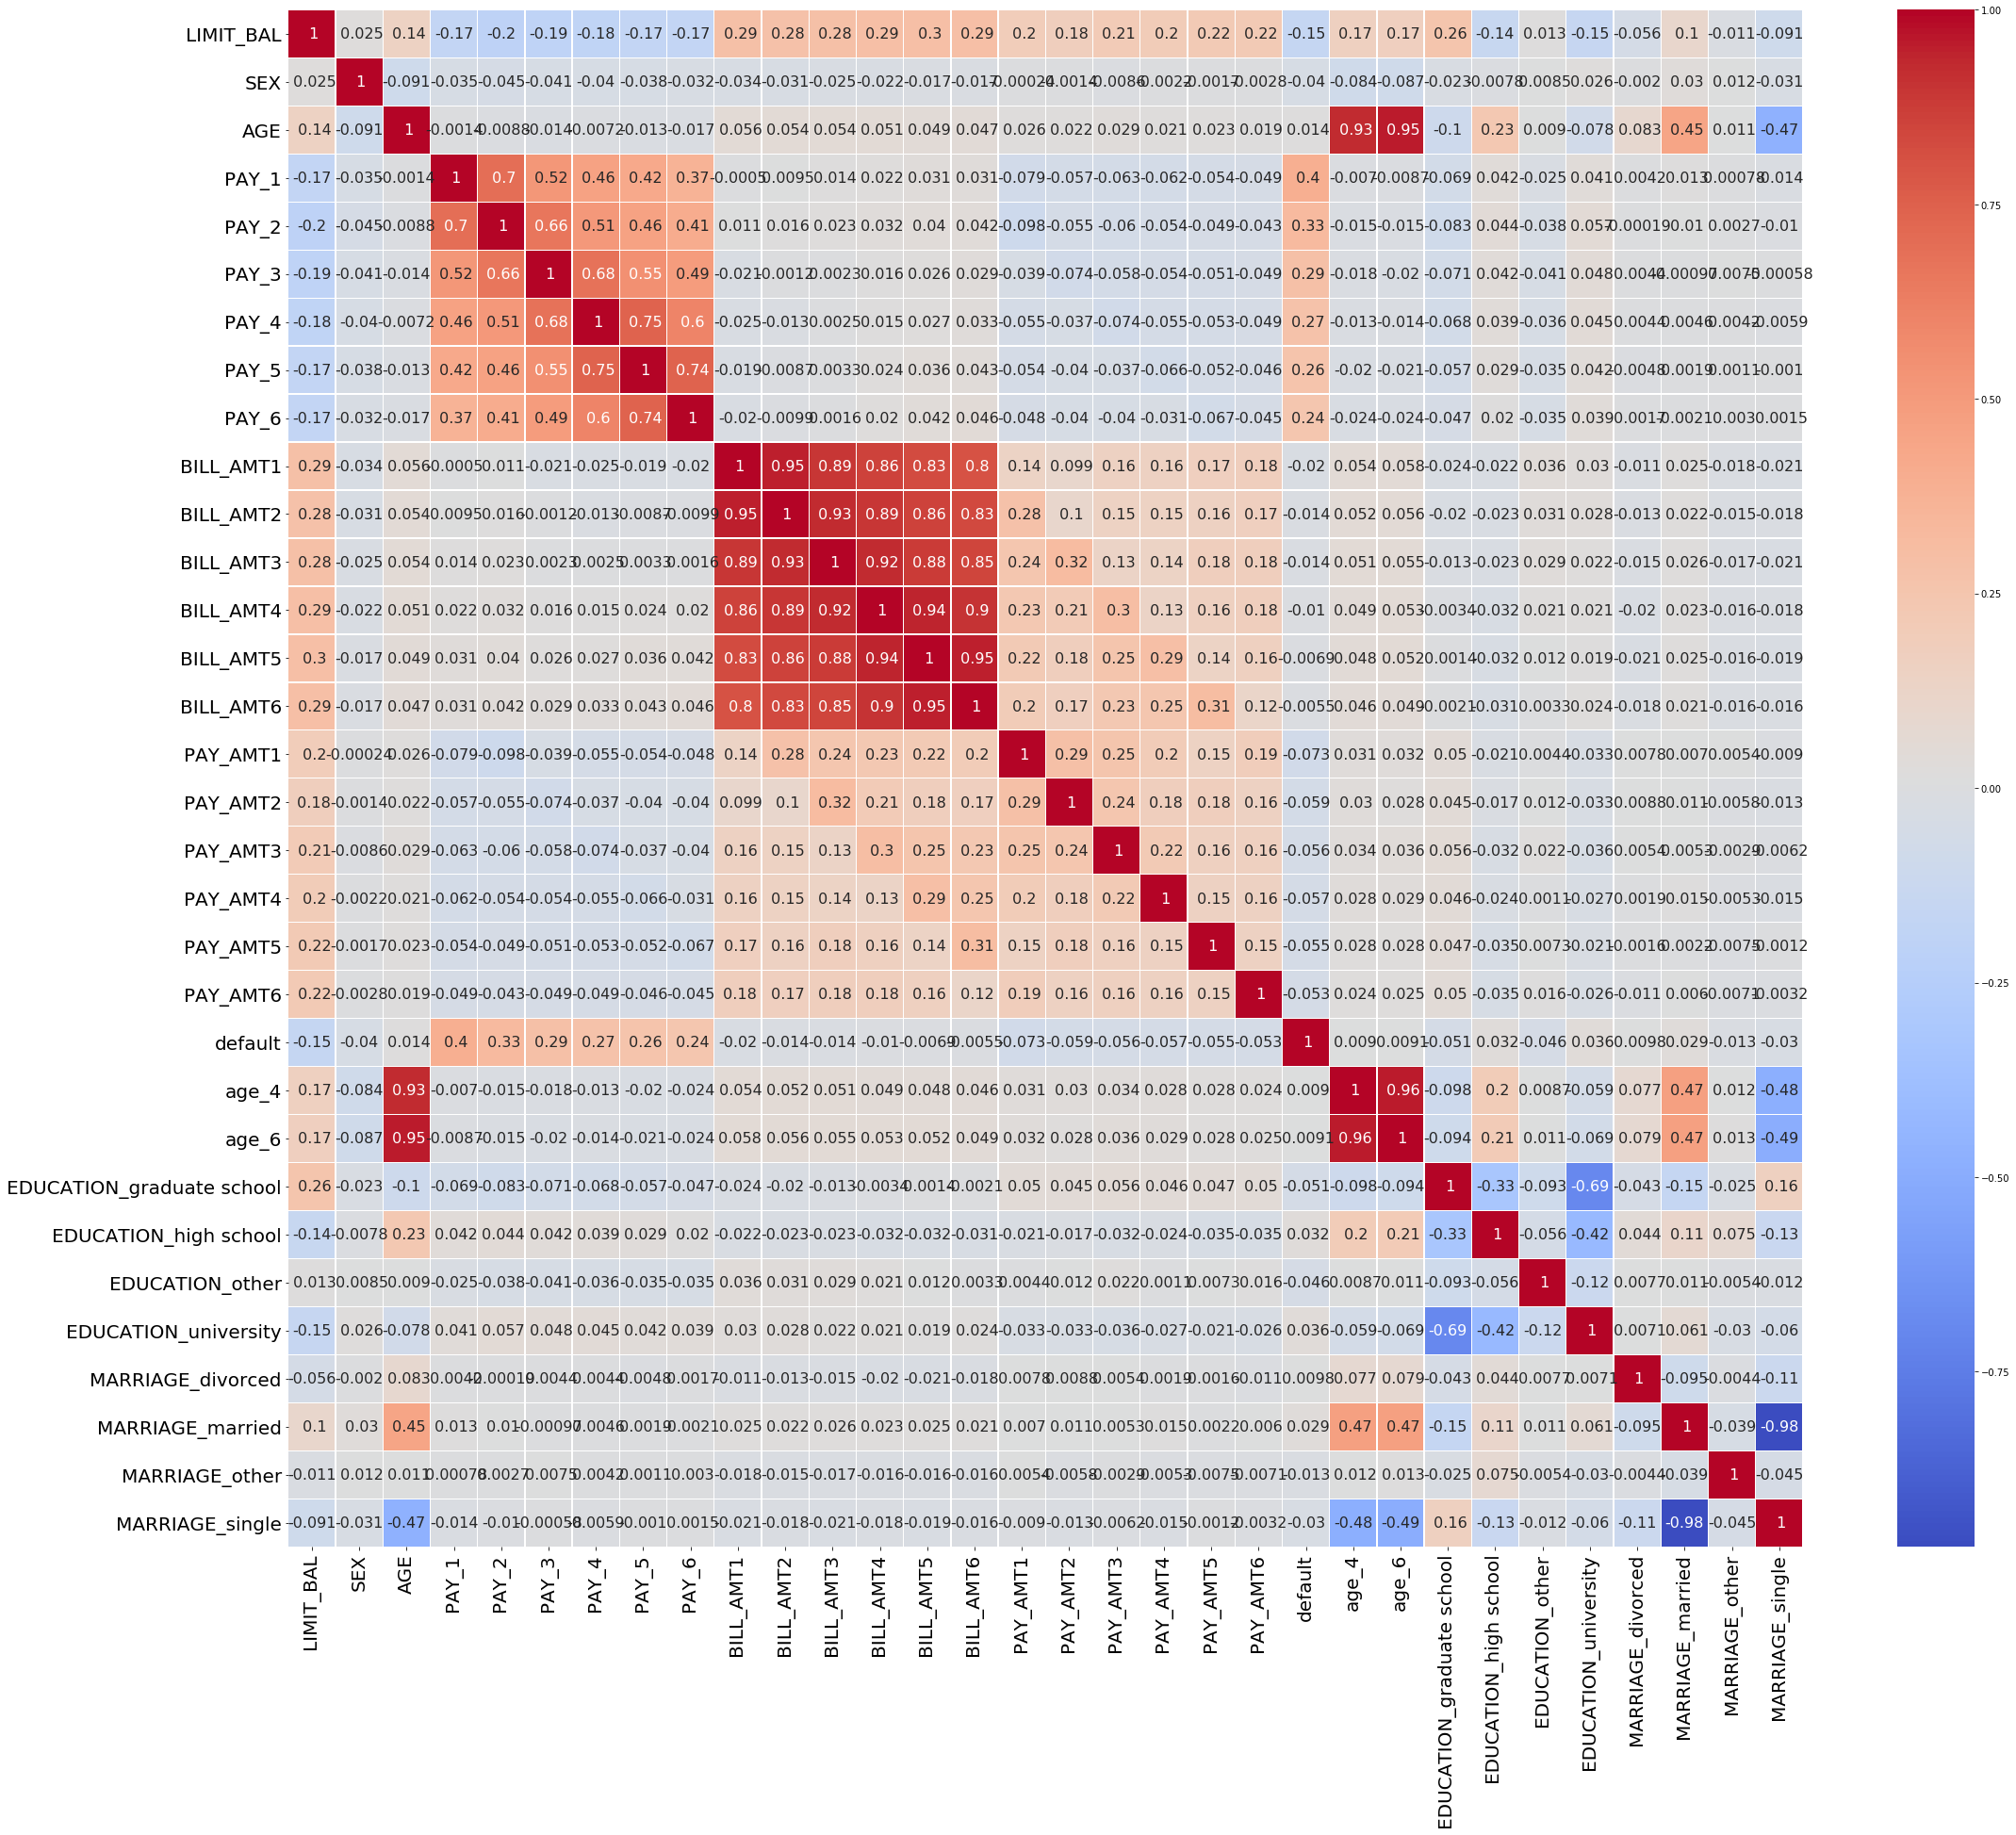

In [4]:
# checking correlation to LIMIT_BAL (target variable)
plt.subplots(figsize=(36,30))
ax = sns.heatmap(credit.corr(), annot = True, annot_kws={'size': 16}, cmap='coolwarm', fmt=' .2g', linewidths = .3)
ax.tick_params(labelsize = 20)

**Findings:** Sex, Marriage, and Education (except Graduate School), and Default have lowest correlation to Limit Balance (target variable). Remove for 2nd dataframe and recheck feature correlation to target variable. Also note that Bill Amounts are highly collinear. 

In [5]:
credit1 = credit.drop(['SEX','EDUCATION_high school','EDUCATION_other','EDUCATION_university','MARRIAGE_divorced','MARRIAGE_married','MARRIAGE_other','MARRIAGE_single','age_4','age_6','default'],axis=1)

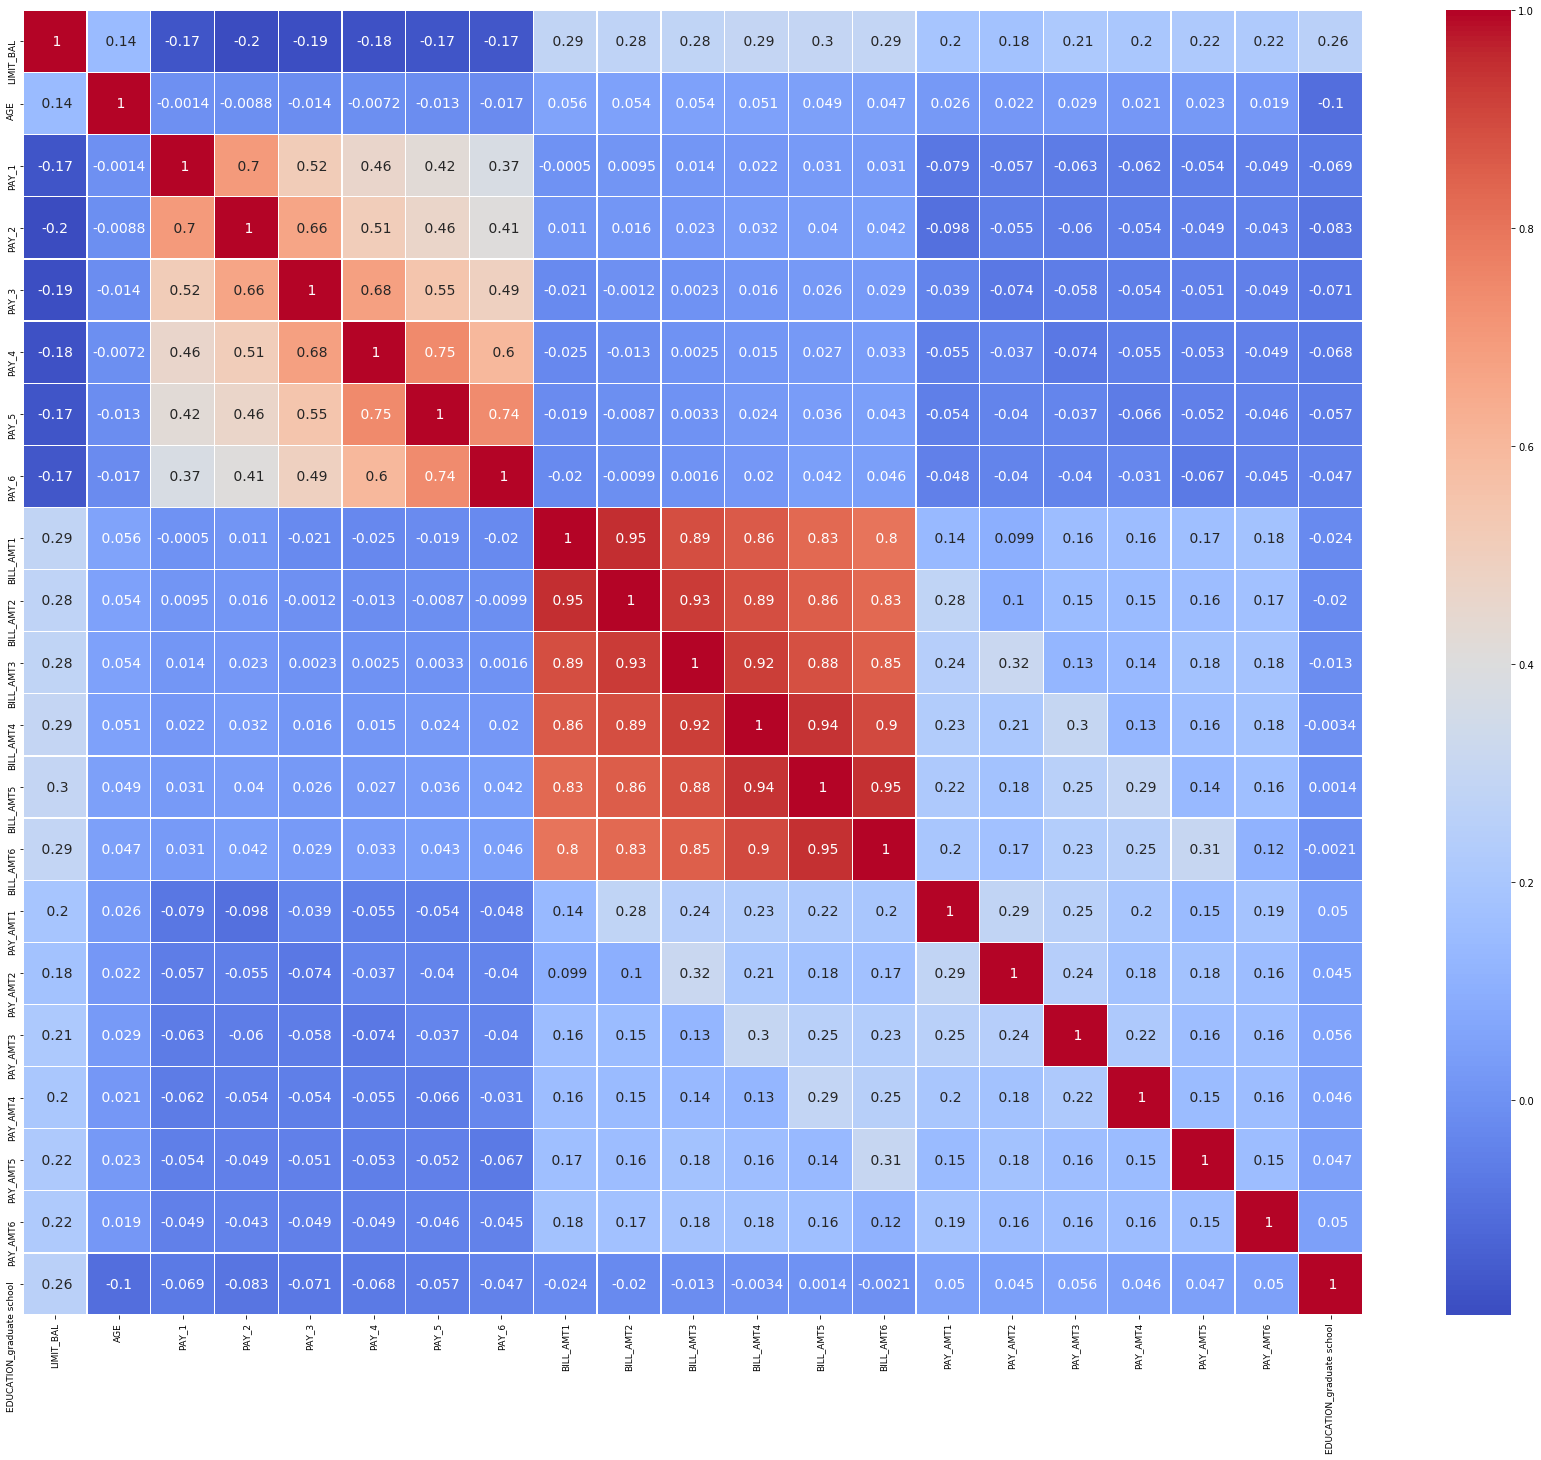

In [6]:
# re-checking correlation to LIMIT_BAL (target variable)
plt.subplots(figsize=(30,24))
ax = sns.heatmap(credit1.corr(), annot = True, annot_kws={'size': 14}, cmap='coolwarm', fmt=' .2g', linewidths = .3)
ax.tick_params(labelsize = 9)

**Findings:** Age and Pay1-Pay6 are also low correlation to target variable, LIMIT_BAL. Remove and keep EDUCATION_graduate school, BILL_AMTs, and PAY_AMTs for 3rd dataframe modeling. Additional feature selection may be done above and beyond for each model.

In [7]:
credit2 = credit1.drop(['AGE','PAY_1','PAY_2','PAY_3','PAY_4','PAY_5','PAY_6'],axis=1)

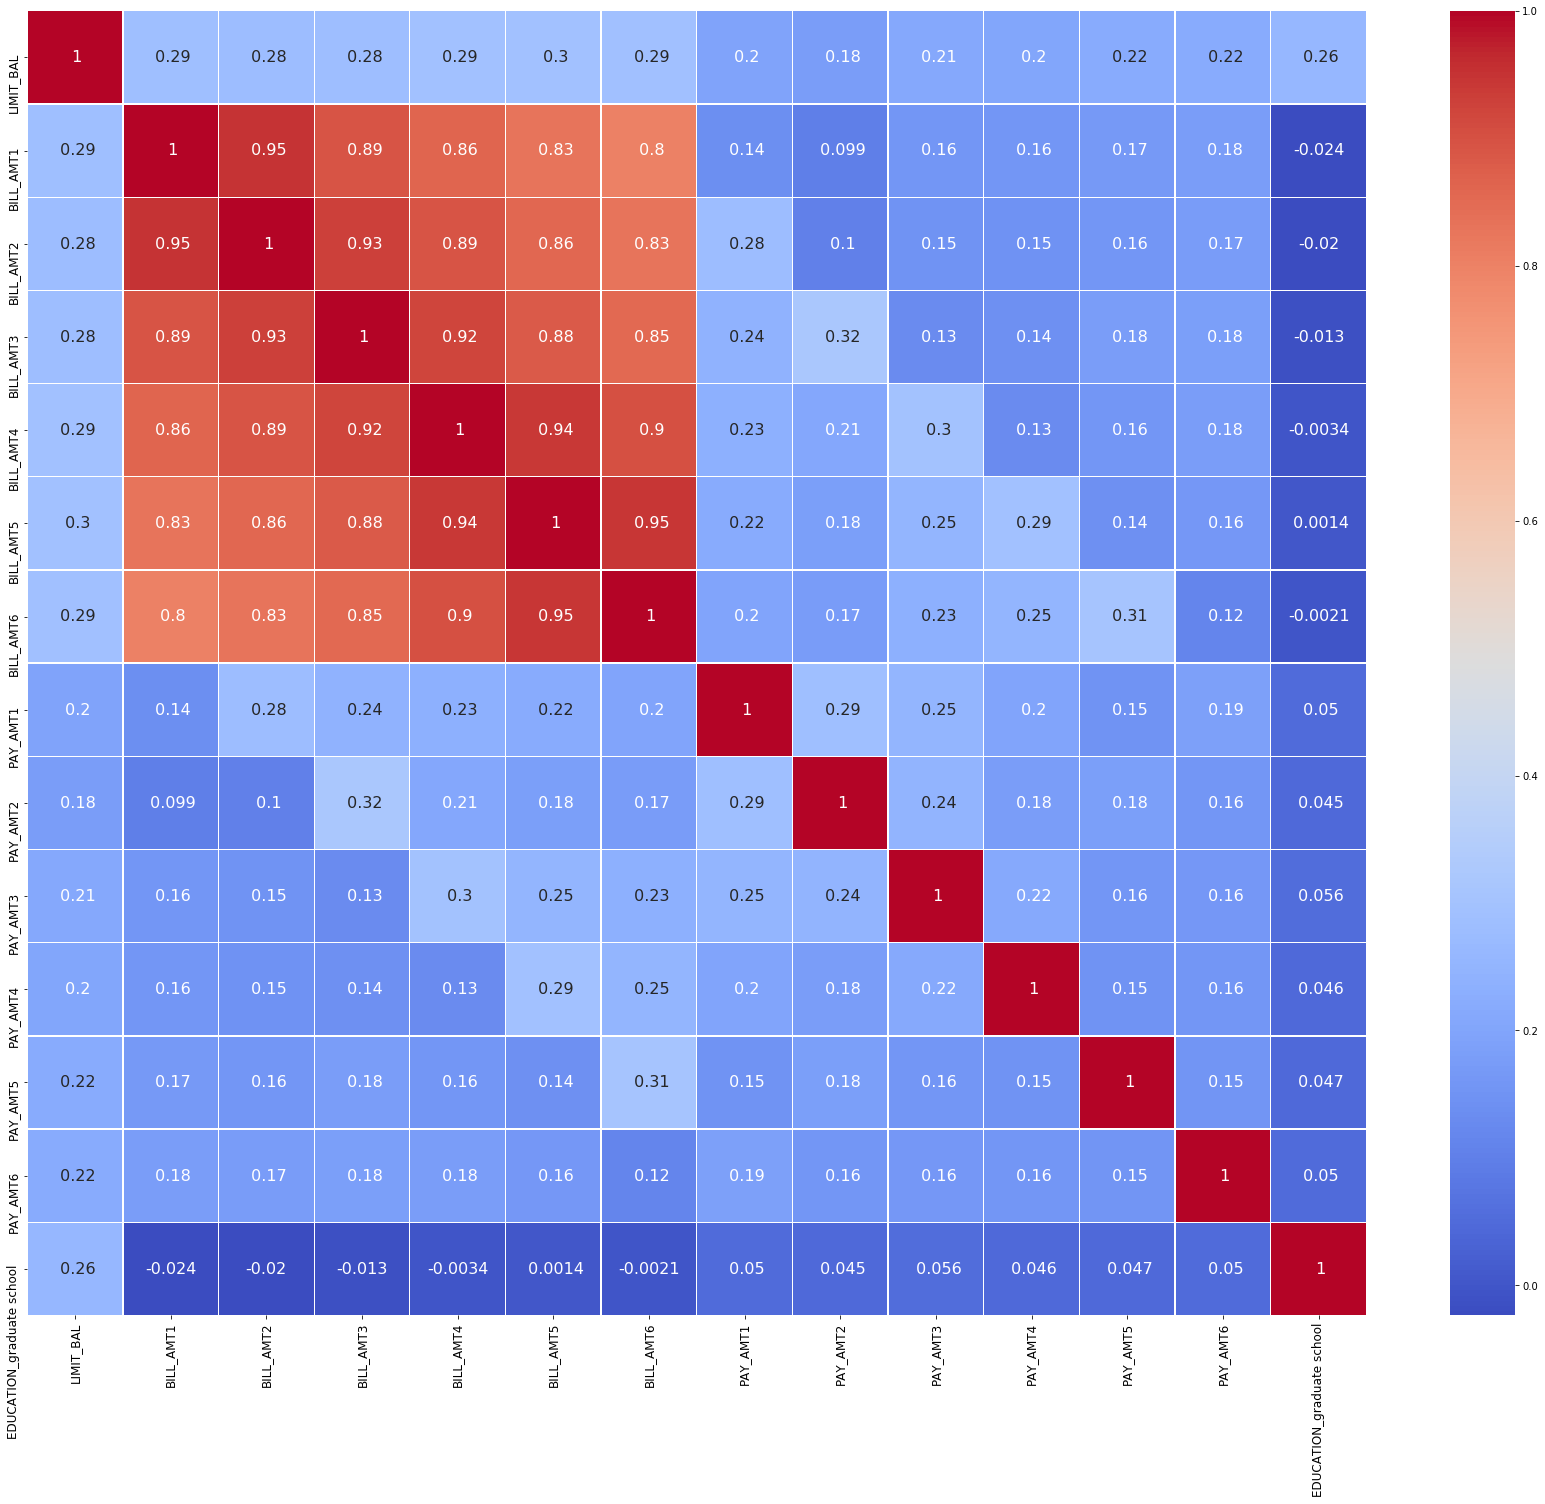

In [8]:
# re-checking correlation to LIMIT_BAL (target variable)
plt.subplots(figsize=(30,24))
ax = sns.heatmap(credit2.corr(), annot = True, annot_kws={'size': 16}, cmap='coolwarm', fmt=' .2g', linewidths = .3)
ax.tick_params(labelsize=12)

#### Modeling - Regression

In [9]:
# features
X = credit.iloc[:,1:]
X.head()

,SEX,AGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,...,age_4,age_6,EDUCATION_graduate school,EDUCATION_high school,EDUCATION_other,EDUCATION_university,MARRIAGE_divorced,MARRIAGE_married,MARRIAGE_other,MARRIAGE_single
0,2,24,2,2,0,0,0,0,3913,3102,...,0,0,0,0,0,1,0,1,0,0
1,2,26,0,2,0,0,0,2,2682,1725,...,0,0,0,0,0,1,0,0,0,1
2,2,34,0,0,0,0,0,0,29239,14027,...,1,2,0,0,0,1,0,0,0,1
3,2,37,0,0,0,0,0,0,46990,48233,...,2,3,0,0,0,1,0,1,0,0
4,1,57,0,0,0,0,0,0,8617,5670,...,3,5,0,0,0,1,0,1,0,0


In [10]:
# target variable
y = credit['LIMIT_BAL']
y.head()

0     20000
1    120000
2     90000
3     50000
4     50000
Name: LIMIT_BAL, dtype: int64

In [11]:
# split for training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .25, random_state = 123)

### The 4 algorithms:

In [12]:
algos_Class = []
algos_Class.append(('Random Forest', RandomForestRegressor()))
algos_Class.append(('Linear Model', LinearRegression()))
algos_Class.append(('SVR', SVR()))
algos_Class.append(('XGBoost', XGBRegressor()))

In [13]:
# regression
# determining cross validation on each algorithm, gold standard for estimating accuracy on unseen data
results = []
names = []
for name, model in algos_Class:
    result = cross_val_score(model, X, y, cv=3, scoring='r2')
    names.append(name)
    results.append(result)

In [14]:
for i in range(len(names)):
    print(names[i],results[i].mean())

Random Forest 0.46498565307295925
Linear Model 0.29340562774499607
SVR -0.05035163400643213
XGBoost 0.46003798348275843


#### Random Forest  and XGBoost are top two. SVR doesn't look promising, however there are 4 kernels I can try tuning (RBF, Poly, Sigmoid, Linear) to see if that increases R2.

### Model 1: Random Forest Regressor

In [15]:
# features
X = credit.iloc[:,1:]
X.head()

,SEX,AGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,...,age_4,age_6,EDUCATION_graduate school,EDUCATION_high school,EDUCATION_other,EDUCATION_university,MARRIAGE_divorced,MARRIAGE_married,MARRIAGE_other,MARRIAGE_single
0,2,24,2,2,0,0,0,0,3913,3102,...,0,0,0,0,0,1,0,1,0,0
1,2,26,0,2,0,0,0,2,2682,1725,...,0,0,0,0,0,1,0,0,0,1
2,2,34,0,0,0,0,0,0,29239,14027,...,1,2,0,0,0,1,0,0,0,1
3,2,37,0,0,0,0,0,0,46990,48233,...,2,3,0,0,0,1,0,1,0,0
4,1,57,0,0,0,0,0,0,8617,5670,...,3,5,0,0,0,1,0,1,0,0


In [16]:
# target variable
y = credit['LIMIT_BAL']
y.head()

0     20000
1    120000
2     90000
3     50000
4     50000
Name: LIMIT_BAL, dtype: int64

In [17]:
# split for training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .25, random_state = 123)

In [18]:
# modeling, tuning hyperparameters
algo = RandomForestRegressor(n_estimators=600)
model = algo.fit(X_train, y_train)

In [19]:
# predictions
preds = model.predict(X_test)
# assessment
print('R2 Scores is: %.3f' % r2_score(y_test, preds))
print('MSE is: %.3f' % mean_squared_error(y_test, preds))
rms = sqrt(mean_squared_error(y_test, preds))
print('RMSE is: %.3f' % rms)

R2 Scores is: 0.474
MSE is: 8738149247.751
RMSE is: 93478.068


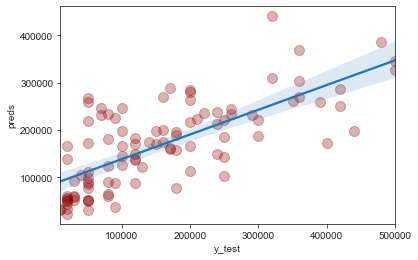

In [20]:
# plotting results
plotDa = pd.DataFrame({'y_test':y_test,'preds':preds})
sns.set_style('ticks')
sns.regplot('y_test', 'preds', data=plotDa.sample(100), fit_reg=True, scatter_kws={'color': 'darkred', 'alpha': 0.3, 's': 100})

**Observation:** This plot visualizes the huge variation in the predictions compared to the regression line. Although there is a linear relationship, we can see the wide deviation of predictions above and below the line, reflecting a lower R2 and high RMSE (cost function).

In [21]:
# modeling, tuning hyperparameters
algo1 = RandomForestRegressor(max_features='sqrt', n_estimators=600, max_depth=10)
model1 = algo1.fit(X_train, y_train)

In [22]:
# predictions
preds = model1.predict(X_test)
# assessment
print('R2 Scores is: %.3f' % r2_score(y_test, preds))
print('MSE is: %.3f' % mean_squared_error(y_test, preds))
rms = sqrt(mean_squared_error(y_test, preds))
print('RMSE is: %.3f' % rms)

R2 Scores is: 0.469
MSE is: 8832638810.125
RMSE is: 93982.120


In [23]:
# modeling, tuning hyperparameters
algo2 = RandomForestRegressor(max_features=5, n_estimators=400, max_depth=10)
model2 = algo2.fit(X_train, y_train)

In [24]:
# predictions
preds = model2.predict(X_test)
# assessment
print('R2 Scores is: %.3f' % r2_score(y_test, preds))
print('MSE is: %.3f' % mean_squared_error(y_test, preds))
rms = sqrt(mean_squared_error(y_test, preds))
print('RMSE is: %.3f' % rms)

R2 Scores is: 0.469
MSE is: 8835940900.136
RMSE is: 93999.686


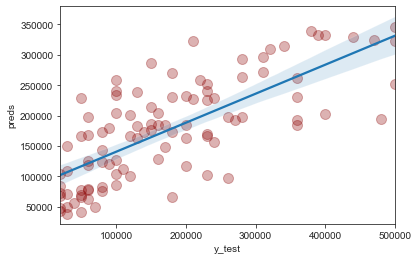

In [25]:
# plotting results
plotDa = pd.DataFrame({'y_test':y_test,'preds':preds})
sns.set_style('ticks')
sns.regplot('y_test', 'preds', data=plotDa.sample(100), fit_reg=True, scatter_kws={'color': 'darkred', 'alpha': 0.3, 's': 100})

**Highest R2 with all Features and tuning: 47.4%**

**Feature Selection: Dropped Sex, Marriage, Education (sans graduate school), and Default**

In [26]:
#features
X = credit1.iloc[:,1:]
X.head()

,AGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,EDUCATION_graduate school
0,24,2,2,0,0,0,0,3913,3102,689,0,0,0,0,689,0,0,0,0,0
1,26,0,2,0,0,0,2,2682,1725,2682,3272,3455,3261,0,1000,1000,1000,0,2000,0
2,34,0,0,0,0,0,0,29239,14027,13559,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,37,0,0,0,0,0,0,46990,48233,49291,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,57,0,0,0,0,0,0,8617,5670,35835,20940,19146,19131,2000,36681,10000,9000,689,679,0


In [27]:
#target variable
y = credit1['LIMIT_BAL']
print(y)

0         20000
1        120000
2         90000
3         50000
4         50000
          ...  
29960    220000
29961    150000
29962     30000
29963     80000
29964     50000
Name: LIMIT_BAL, Length: 29965, dtype: int64


In [28]:
#split for training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .25, random_state = 123)

In [29]:
#Modeling, tuning hyperparameters
algo = RandomForestRegressor(max_features=5, n_estimators=600, max_depth=20)
model = algo.fit(X_train, y_train)

In [30]:
#Predictions
preds = model.predict(X_test)
#Assessment
print('R2 Scores is: %.3f' % r2_score(y_test, preds))
print('MSE is: %.3f' % mean_squared_error(y_test, preds))
rms = sqrt(mean_squared_error(y_test, preds))
print('RMSE is: %.3f' % rms)

R2 Scores is: 0.482
MSE is: 8618739205.588
RMSE is: 92837.165


**Highest R2 with first Feature Selection and Tuning: 48.2%**

**Feature Selection: Dropped Age and Pay Statuses**

In [31]:
#features
X = credit2.iloc[:,1:]
X.head()

,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,EDUCATION_graduate school
0,3913,3102,689,0,0,0,0,689,0,0,0,0,0
1,2682,1725,2682,3272,3455,3261,0,1000,1000,1000,0,2000,0
2,29239,14027,13559,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,46990,48233,49291,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,8617,5670,35835,20940,19146,19131,2000,36681,10000,9000,689,679,0


In [32]:
#target variable
y = credit2['LIMIT_BAL']
print(y)

0         20000
1        120000
2         90000
3         50000
4         50000
          ...  
29960    220000
29961    150000
29962     30000
29963     80000
29964     50000
Name: LIMIT_BAL, Length: 29965, dtype: int64


In [33]:
#split for training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .25, random_state = 123)

In [34]:
#Modeling, tuning hyperparameters
algo = RandomForestRegressor(max_features=5, n_estimators=600, max_depth=20)
model = algo.fit(X_train, y_train)

In [35]:
#Predictions
preds = model.predict(X_test)
#Assessment
print('R2 Scores is: %.3f' % r2_score(y_test, preds))
print('MSE is: %.3f' % mean_squared_error(y_test, preds))
rms = sqrt(mean_squared_error(y_test, preds))
print('RMSE is: %.3f' % rms)

R2 Scores is: 0.432
MSE is: 9446319324.193
RMSE is: 97192.177


In [36]:
#features
X = credit[['BILL_AMT1','BILL_AMT5','PAY_AMT1','PAY_AMT5','EDUCATION_graduate school']]
X.head()

,BILL_AMT1,BILL_AMT5,PAY_AMT1,PAY_AMT5,EDUCATION_graduate school
0,3913,0,0,0,0
1,2682,3455,0,0,0
2,29239,14948,1518,1000,0
3,46990,28959,2000,1069,0
4,8617,19146,2000,689,0


In [37]:
#target variable
y = credit['LIMIT_BAL']
print(y)

0         20000
1        120000
2         90000
3         50000
4         50000
          ...  
29960    220000
29961    150000
29962     30000
29963     80000
29964     50000
Name: LIMIT_BAL, Length: 29965, dtype: int64


In [38]:
#split for training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .25, random_state = 123)

In [39]:
#Modeling, tuning hyperparameters
algo = RandomForestRegressor(n_estimators=600, max_depth=20, max_features=5)
model = algo.fit(X_train, y_train)

In [40]:
#Predictions
preds = model.predict(X_test)
#Assessment
print('R2 Scores is: %.3f' % r2_score(y_test, preds))
print('MSE is: %.3f' % mean_squared_error(y_test, preds))
rms = sqrt(mean_squared_error(y_test, preds))
print('RMSE is: %.3f' % rms)

R2 Scores is: 0.353
MSE is: 10751537153.904
RMSE is: 103689.619


**Highest R2 with additional Feature Selection and Tuning: 35.4%**

### Top R2 with Random Forest Regressor: 48.3% - not better than educated guess

### Model 2: Linear Regression

In [41]:
#features
X = credit.iloc[:,1:]
X.head()

,SEX,AGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,...,age_4,age_6,EDUCATION_graduate school,EDUCATION_high school,EDUCATION_other,EDUCATION_university,MARRIAGE_divorced,MARRIAGE_married,MARRIAGE_other,MARRIAGE_single
0,2,24,2,2,0,0,0,0,3913,3102,...,0,0,0,0,0,1,0,1,0,0
1,2,26,0,2,0,0,0,2,2682,1725,...,0,0,0,0,0,1,0,0,0,1
2,2,34,0,0,0,0,0,0,29239,14027,...,1,2,0,0,0,1,0,0,0,1
3,2,37,0,0,0,0,0,0,46990,48233,...,2,3,0,0,0,1,0,1,0,0
4,1,57,0,0,0,0,0,0,8617,5670,...,3,5,0,0,0,1,0,1,0,0


In [42]:
#target variable
y = credit['LIMIT_BAL']
y.head()

0     20000
1    120000
2     90000
3     50000
4     50000
Name: LIMIT_BAL, dtype: int64

In [43]:
#split for training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .25, random_state = 123)

In [44]:
algo = LinearRegression()
pprint(algo.get_params())

{'copy_X': True, 'fit_intercept': True, 'n_jobs': None, 'normalize': False}


In [45]:
#Modeling, tuning hyperparameters
algo = LinearRegression(normalize=True)
model = algo.fit(X_train, y_train)

In [46]:
#Predictions
preds = model.predict(X_test)
#Assessment
print('R2 Scores is: %.3f' % r2_score(y_test, preds))
print('MSE is: %.3f' % mean_squared_error(y_test, preds))
rms = sqrt(mean_squared_error(y_test, preds))
print('RMSE is: %.3f' % rms)

R2 Scores is: 0.284
MSE is: 11909083934.069
RMSE is: 109128.749


In [47]:
#features
X = credit1.iloc[:,1:]
X.head()

,AGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,EDUCATION_graduate school
0,24,2,2,0,0,0,0,3913,3102,689,0,0,0,0,689,0,0,0,0,0
1,26,0,2,0,0,0,2,2682,1725,2682,3272,3455,3261,0,1000,1000,1000,0,2000,0
2,34,0,0,0,0,0,0,29239,14027,13559,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,37,0,0,0,0,0,0,46990,48233,49291,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,57,0,0,0,0,0,0,8617,5670,35835,20940,19146,19131,2000,36681,10000,9000,689,679,0


In [48]:
#target variable
y = credit1['LIMIT_BAL']
y.head()

0     20000
1    120000
2     90000
3     50000
4     50000
Name: LIMIT_BAL, dtype: int64

In [49]:
#split for training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .25, random_state = 123)

In [50]:
#Modeling, tuning hyperparameters
algo2 = LinearRegression(normalize=True)
model2 = algo2.fit(X_train, y_train)

In [51]:
#Predictions
preds = model2.predict(X_test)
#Assessment
print('R2 Scores is: %.3f' % r2_score(y_test, preds))
print('MSE is: %.3f' % mean_squared_error(y_test, preds))
rms = sqrt(mean_squared_error(y_test, preds))
print('RMSE is: %.3f' % rms)

R2 Scores is: 0.255
MSE is: 12383404298.957
RMSE is: 111280.745


In [52]:
#features
X = credit2.iloc[:,1:]
X.head()

,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,EDUCATION_graduate school
0,3913,3102,689,0,0,0,0,689,0,0,0,0,0
1,2682,1725,2682,3272,3455,3261,0,1000,1000,1000,0,2000,0
2,29239,14027,13559,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,46990,48233,49291,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,8617,5670,35835,20940,19146,19131,2000,36681,10000,9000,689,679,0


In [53]:
#target variable
y = credit['LIMIT_BAL']
y.head()

0     20000
1    120000
2     90000
3     50000
4     50000
Name: LIMIT_BAL, dtype: int64

In [54]:
#split for training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .25, random_state = 123)

In [55]:
#Modeling, tuning hyperparameters
algo3 = LinearRegression(normalize=True)
model3 = algo3.fit(X_train, y_train)

In [56]:
#Predictions
preds = model3.predict(X_test)
#Assessment
print('R2 Scores is: %.3f' % r2_score(y_test, preds))
print('MSE is: %.3f' % mean_squared_error(y_test, preds))
rms = sqrt(mean_squared_error(y_test, preds))
print('RMSE is: %.3f' % rms)

R2 Scores is: 0.188
MSE is: 13496851963.171
RMSE is: 116175.953


### Top R2 with Linear Modeling: 28.4% - move on

### Model 3: Support Vector Regression (SVR)

**RBF Kernel**

In [57]:
#features
X = credit.iloc[:,1:]
X.head()

,SEX,AGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,...,age_4,age_6,EDUCATION_graduate school,EDUCATION_high school,EDUCATION_other,EDUCATION_university,MARRIAGE_divorced,MARRIAGE_married,MARRIAGE_other,MARRIAGE_single
0,2,24,2,2,0,0,0,0,3913,3102,...,0,0,0,0,0,1,0,1,0,0
1,2,26,0,2,0,0,0,2,2682,1725,...,0,0,0,0,0,1,0,0,0,1
2,2,34,0,0,0,0,0,0,29239,14027,...,1,2,0,0,0,1,0,0,0,1
3,2,37,0,0,0,0,0,0,46990,48233,...,2,3,0,0,0,1,0,1,0,0
4,1,57,0,0,0,0,0,0,8617,5670,...,3,5,0,0,0,1,0,1,0,0


In [58]:
#target variable
y = credit['LIMIT_BAL']
y.head()

0     20000
1    120000
2     90000
3     50000
4     50000
Name: LIMIT_BAL, dtype: int64

In [59]:
#split for training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .25, random_state = 123)

In [60]:
rbf = SVR()

In [61]:
#Parameters in use
pprint(rbf.get_params())

{'C': 1.0,
 'cache_size': 200,
 'coef0': 0.0,
 'degree': 3,
 'epsilon': 0.1,
 'gamma': 'scale',
 'kernel': 'rbf',
 'max_iter': -1,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}


In [62]:
#Modeling RBF Kernel, tuning hyperparameters
rbf = SVR()
model_rbf = rbf.fit(X_train, y_train)

In [63]:
rbf_grid = {
    'C': [1, 10, 100, 1000, 10000, 100000]
}

In [64]:
gs_rbf = GridSearchCV(estimator=rbf, param_grid=rbf_grid, cv=3, n_jobs=-1)
gs_rbf.fit(X_train, y_train)

GridSearchCV(cv=3, error_score=nan,
             estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3,
                           epsilon=0.1, gamma='scale', kernel='rbf',
                           max_iter=-1, shrinking=True, tol=0.001,
                           verbose=False),
             iid='deprecated', n_jobs=-1,
             param_grid={'C': [1, 10, 100, 1000, 10000, 100000]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [65]:
gs_rbf.best_params_

{'C': 100000}

In [66]:
#Modeling RBF Kernel, tuning hyperparameters
rbf = SVR(C=100000)
model_rbf = rbf.fit(X_train, y_train)

In [67]:
#Predictions
preds = model_rbf.predict(X_test)
#Assessment
print('R2 Scores is: %.3f' % r2_score(y_test, preds))
print('MSE is: %.3f' % mean_squared_error(y_test, preds))
rms = sqrt(mean_squared_error(y_test, preds))
print('RMSE is: %.3f' % rms)

R2 Scores is: 0.335
MSE is: 11048868025.111
RMSE is: 105113.596


In [68]:
#features
X = credit1.iloc[:,1:]
X.head()

,AGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,EDUCATION_graduate school
0,24,2,2,0,0,0,0,3913,3102,689,0,0,0,0,689,0,0,0,0,0
1,26,0,2,0,0,0,2,2682,1725,2682,3272,3455,3261,0,1000,1000,1000,0,2000,0
2,34,0,0,0,0,0,0,29239,14027,13559,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,37,0,0,0,0,0,0,46990,48233,49291,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,57,0,0,0,0,0,0,8617,5670,35835,20940,19146,19131,2000,36681,10000,9000,689,679,0


In [69]:
#target variable
y = credit1['LIMIT_BAL']
y.head()

0     20000
1    120000
2     90000
3     50000
4     50000
Name: LIMIT_BAL, dtype: int64

In [70]:
#split for training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .25, random_state = 123)

In [71]:
#Modeling RBF Kernel, tuning hyperparameters
rbf = SVR(C=100000)
model_rbf = rbf.fit(X_train, y_train)

In [72]:
#Predictions
preds = model_rbf.predict(X_test)
#Assessment
print('R2 Scores is: %.3f' % r2_score(y_test, preds))
print('MSE is: %.3f' % mean_squared_error(y_test, preds))
rms = sqrt(mean_squared_error(y_test, preds))
print('RMSE is: %.3f' % rms)

R2 Scores is: 0.336
MSE is: 11034777126.308
RMSE is: 105046.547


In [73]:
#features
X = credit2.iloc[:,1:]
X.head()

,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,EDUCATION_graduate school
0,3913,3102,689,0,0,0,0,689,0,0,0,0,0
1,2682,1725,2682,3272,3455,3261,0,1000,1000,1000,0,2000,0
2,29239,14027,13559,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,46990,48233,49291,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,8617,5670,35835,20940,19146,19131,2000,36681,10000,9000,689,679,0


In [74]:
#target variable
y = credit2['LIMIT_BAL']
y.head()

0     20000
1    120000
2     90000
3     50000
4     50000
Name: LIMIT_BAL, dtype: int64

In [75]:
#split for training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .25, random_state = 123)

In [76]:
#Modeling RBF Kernel, tuning hyperparameters
rbf = SVR(C=100000)
model_rbf = rbf.fit(X_train, y_train)

In [77]:
#Predictions
preds = model_rbf.predict(X_test)
#Assessment
print('R2 Scores is: %.3f' % r2_score(y_test, preds))
print('MSE is: %.3f' % mean_squared_error(y_test, preds))
rms = sqrt(mean_squared_error(y_test, preds))
print('RMSE is: %.3f' % rms)

R2 Scores is: 0.337
MSE is: 11021259771.956
RMSE is: 104982.188


In [78]:
#features
X = credit2[['BILL_AMT1','BILL_AMT5','PAY_AMT1','PAY_AMT5','EDUCATION_graduate school']]
X.head()

,BILL_AMT1,BILL_AMT5,PAY_AMT1,PAY_AMT5,EDUCATION_graduate school
0,3913,0,0,0,0
1,2682,3455,0,0,0
2,29239,14948,1518,1000,0
3,46990,28959,2000,1069,0
4,8617,19146,2000,689,0


In [79]:
#target variable
y = credit2['LIMIT_BAL']
y.head()

0     20000
1    120000
2     90000
3     50000
4     50000
Name: LIMIT_BAL, dtype: int64

In [80]:
#split for training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .25, random_state = 123)

In [81]:
#Modeling RBF Kernel, tuning hyperparameters
rbf = SVR(C=100000)
model_rbf = rbf.fit(X_train, y_train)

In [82]:
#Predictions
preds = model_rbf.predict(X_test)
#Assessment
print('R2 Scores is: %.3f' % r2_score(y_test, preds))
print('MSE is: %.3f' % mean_squared_error(y_test, preds))
rms = sqrt(mean_squared_error(y_test, preds))
print('RMSE is: %.3f' % rms)

R2 Scores is: 0.264
MSE is: 12236433795.840
RMSE is: 110618.415


### Top R2 with RBF Kernel and Tuning: 33.7%

**Polynomial Kernel**

In [83]:
#features
X = credit.iloc[:,1:]
X.head()

,SEX,AGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,...,age_4,age_6,EDUCATION_graduate school,EDUCATION_high school,EDUCATION_other,EDUCATION_university,MARRIAGE_divorced,MARRIAGE_married,MARRIAGE_other,MARRIAGE_single
0,2,24,2,2,0,0,0,0,3913,3102,...,0,0,0,0,0,1,0,1,0,0
1,2,26,0,2,0,0,0,2,2682,1725,...,0,0,0,0,0,1,0,0,0,1
2,2,34,0,0,0,0,0,0,29239,14027,...,1,2,0,0,0,1,0,0,0,1
3,2,37,0,0,0,0,0,0,46990,48233,...,2,3,0,0,0,1,0,1,0,0
4,1,57,0,0,0,0,0,0,8617,5670,...,3,5,0,0,0,1,0,1,0,0


In [84]:
#target variable
y = credit['LIMIT_BAL']
y.head()

0     20000
1    120000
2     90000
3     50000
4     50000
Name: LIMIT_BAL, dtype: int64

In [85]:
#split for training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .25, random_state = 123)

In [86]:
poly = SVR(kernel='poly')

In [87]:
#Parameters in use
pprint(poly.get_params())

{'C': 1.0,
 'cache_size': 200,
 'coef0': 0.0,
 'degree': 3,
 'epsilon': 0.1,
 'gamma': 'scale',
 'kernel': 'poly',
 'max_iter': -1,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}


In [88]:
poly_grid = {
    'C': [0.1, 1, 10],
    'degree': [2, 3],
    'epsilon': [0.1, 1, 5]
}

In [89]:
gs_poly = GridSearchCV(estimator=poly, param_grid=poly_grid, cv=3, n_jobs=-1)
gs_poly.fit(X_train, y_train)

GridSearchCV(cv=3, error_score=nan,
             estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3,
                           epsilon=0.1, gamma='scale', kernel='poly',
                           max_iter=-1, shrinking=True, tol=0.001,
                           verbose=False),
             iid='deprecated', n_jobs=-1,
             param_grid={'C': [0.1, 1, 10], 'degree': [2, 3],
                         'epsilon': [0.1, 1, 5]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [90]:
gs_poly.best_params_

{'C': 10, 'degree': 2, 'epsilon': 1}

In [91]:
#Modeling Polynomial Kernel, tuning hyperparameters
poly = SVR(kernel='poly', C=10, degree=2, epsilon=1)
model_poly = poly.fit(X_train, y_train)

In [92]:
#Predictions
preds = model_poly.predict(X_test)
#Assessment
print('R2 Scores is: %.3f' % r2_score(y_test, preds))
print('MSE is: %.3f' % mean_squared_error(y_test, preds))
rms = sqrt(mean_squared_error(y_test, preds))
print('RMSE is: %.3f' % rms)

R2 Scores is: 0.056
MSE is: 15697170674.945
RMSE is: 125288.350


In [93]:
#features
X = credit2.iloc[:,1:]
X.head()

,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,EDUCATION_graduate school
0,3913,3102,689,0,0,0,0,689,0,0,0,0,0
1,2682,1725,2682,3272,3455,3261,0,1000,1000,1000,0,2000,0
2,29239,14027,13559,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,46990,48233,49291,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,8617,5670,35835,20940,19146,19131,2000,36681,10000,9000,689,679,0


In [94]:
#target variable
y = credit2['LIMIT_BAL']
y.head()

0     20000
1    120000
2     90000
3     50000
4     50000
Name: LIMIT_BAL, dtype: int64

In [95]:
#split for training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .25, random_state = 123)

In [96]:
#Modeling Polynomial Kernel, tuning hyperparameters
poly = SVR(kernel='poly', degree=2)
model_poly = poly.fit(X_train, y_train)

In [97]:
#Predictions
preds = model_poly.predict(X_test)
#Assessment
print('R2 Scores is: %.3f' % r2_score(y_test, preds))
print('MSE is: %.3f' % mean_squared_error(y_test, preds))
rms = sqrt(mean_squared_error(y_test, preds))
print('RMSE is: %.3f' % rms)

R2 Scores is: 0.063
MSE is: 15584764503.539
RMSE is: 124838.954


### Top R2 result with Polynomial Kernel, Feature Selection, and Tuning: 5.7%

**Sigmoid Kernel**

In [98]:
#features
X = credit.iloc[:,1:]
X.head()

,SEX,AGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,...,age_4,age_6,EDUCATION_graduate school,EDUCATION_high school,EDUCATION_other,EDUCATION_university,MARRIAGE_divorced,MARRIAGE_married,MARRIAGE_other,MARRIAGE_single
0,2,24,2,2,0,0,0,0,3913,3102,...,0,0,0,0,0,1,0,1,0,0
1,2,26,0,2,0,0,0,2,2682,1725,...,0,0,0,0,0,1,0,0,0,1
2,2,34,0,0,0,0,0,0,29239,14027,...,1,2,0,0,0,1,0,0,0,1
3,2,37,0,0,0,0,0,0,46990,48233,...,2,3,0,0,0,1,0,1,0,0
4,1,57,0,0,0,0,0,0,8617,5670,...,3,5,0,0,0,1,0,1,0,0


In [99]:
#target variable
y = credit['LIMIT_BAL']
y.head()

0     20000
1    120000
2     90000
3     50000
4     50000
Name: LIMIT_BAL, dtype: int64

In [100]:
#split for training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .25, random_state = 123)

In [101]:
sig = SVR(kernel='sigmoid')

In [102]:
#Parameters in use
pprint(sig.get_params())

{'C': 1.0,
 'cache_size': 200,
 'coef0': 0.0,
 'degree': 3,
 'epsilon': 0.1,
 'gamma': 'scale',
 'kernel': 'sigmoid',
 'max_iter': -1,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}


In [103]:
sig_grid = {
    'C': [0.01, 0.1, 1, 10]
}

In [104]:
gs_sig = GridSearchCV(estimator=sig, param_grid=sig_grid, cv=3, n_jobs=-1)
gs_sig.fit(X_train, y_train)

GridSearchCV(cv=3, error_score=nan,
             estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3,
                           epsilon=0.1, gamma='scale', kernel='sigmoid',
                           max_iter=-1, shrinking=True, tol=0.001,
                           verbose=False),
             iid='deprecated', n_jobs=-1, param_grid={'C': [0.01, 0.1, 1, 10]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [105]:
gs_sig.best_params_

{'C': 0.01}

In [106]:
#Modeling Sigmoid Kernel, tuning hyperparameters
sig = SVR(kernel='sigmoid', C=0.01)
model_sig = sig.fit(X_train, y_train)

In [107]:
#Predictions
preds = model_sig.predict(X_test)
#Assessment
print('R2 Scores is: %.3f' % r2_score(y_test, preds))
print('MSE is: %.3f' % mean_squared_error(y_test, preds))
rms = sqrt(mean_squared_error(y_test, preds))
print('RMSE is: %.3f' % rms)

R2 Scores is: -0.044
MSE is: 17360698376.645
RMSE is: 131760.003


### Sigmoid Kernel with Tuning did not work

### XGBRegressor

In [108]:
#features
X = credit.iloc[:,1:]
X.head()

,SEX,AGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,...,age_4,age_6,EDUCATION_graduate school,EDUCATION_high school,EDUCATION_other,EDUCATION_university,MARRIAGE_divorced,MARRIAGE_married,MARRIAGE_other,MARRIAGE_single
0,2,24,2,2,0,0,0,0,3913,3102,...,0,0,0,0,0,1,0,1,0,0
1,2,26,0,2,0,0,0,2,2682,1725,...,0,0,0,0,0,1,0,0,0,1
2,2,34,0,0,0,0,0,0,29239,14027,...,1,2,0,0,0,1,0,0,0,1
3,2,37,0,0,0,0,0,0,46990,48233,...,2,3,0,0,0,1,0,1,0,0
4,1,57,0,0,0,0,0,0,8617,5670,...,3,5,0,0,0,1,0,1,0,0


In [109]:
#target variable
y = credit['LIMIT_BAL']
y.head()

0     20000
1    120000
2     90000
3     50000
4     50000
Name: LIMIT_BAL, dtype: int64

In [110]:
#split for training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .25, random_state = 123)

In [111]:
#Modeling, tuning hyperparameters
algo = XGBRegressor(n_estimators=50, max_depth=5)
model = algo.fit(X_train, y_train)

In [112]:
#Predictions
preds = model.predict(X_test)
#Assessment
print('R2 Scores is: %.3f' % r2_score(y_test, preds))
print('MSE is: %.3f' % mean_squared_error(y_test, preds))
rms = sqrt(mean_squared_error(y_test, preds))
print('RMSE is: %.3f' % rms)

R2 Scores is: 0.486
MSE is: 8554265728.038
RMSE is: 92489.274


In [113]:
plotDa = pd.DataFrame({'y_test':y_test,'preds':preds})

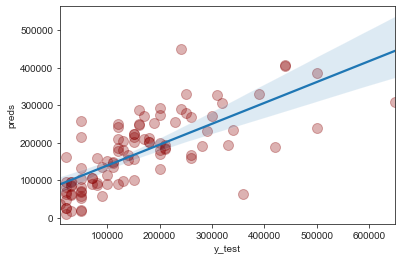

In [114]:
sns.set_style('ticks')
sns.regplot('y_test', 'preds', data=plotDa.sample(100), fit_reg=True, scatter_kws={'color': 'darkred', 'alpha': 0.3, 's': 100})

### Top R2 with XGBRegressor and Tuning: 48.6%

**Linear Kernel**

In [115]:
#features
X = credit[['BILL_AMT1','default']]
X.head()

,BILL_AMT1,default
0,3913,1
1,2682,1
2,29239,0
3,46990,0
4,8617,0


In [116]:
#target variable
y = credit['LIMIT_BAL']
y.head()

0     20000
1    120000
2     90000
3     50000
4     50000
Name: LIMIT_BAL, dtype: int64

In [117]:
#split for training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .25, random_state = 123)

In [ ]:
#Modeling Sigmoid Kernel, tuning hyperparameters
lin = SVR(kernel='linear')
model_lin = lin.fit(X_train, y_train)

In [ ]:
#Predictions
preds = model_lin.predict(X_test)
#Assessment
print('R2 Scores is: %.3f' % r2_score(y_test, preds))
print('MSE is: %.3f' % mean_squared_error(y_test, preds))
rms = sqrt(mean_squared_error(y_test, preds))
print('RMSE is: %.3f' % rms)

### Numerous attempts to run a linear kernel resulted in kernel running 3+ hours with no output. Linear kernel terminated multiple times due to no output.

### Conclusion:
The highest R-Squared achieved to predict credit limit was 48.6% (XGBRegressor). This is not better than an educated guess of 50%. 

Another method to predict credit limit is to bin credit limit into categories (as opposed to a continuous number ranging from 10,000 to 1,000,000), thereby turning the modeling effort into a classification modeling problem. 

**Next Step:** Bin credit limit into equal-sized categories and use classification alogrithms, to include Random Forest Classifier, Support Vector Classifier, Xtreme Gradient Boosting Classifier, and Decision Tree Classification.